# 2. Exploratory Data Analysis
#### (20 points, due Monday 6th April)

#### Corday Selden

*Assignment:*
Create a Jupyter notebook to perform exploratory data analysis for all of the different data types that you intend to use for your project. You should determine and describe with appropriate figures (don't forget axis labels, units, titles, etc...) and short paragraphs of text:

- a clear description of each data type with information on how to access it. If it's your own data, just state that, if you have accessed the data from some other source provide enough information for someone else to access it.
- the spatial and temporal coverage of each of your data types.
- the level of overlap in coverage and resolution of your different data types.

*This Notebook is organized as follows:  (1) target dataset i.e. N2 fixation rate measurements, (2) predictor dataset 1 i.e. CTD profiles, and (3) predictor dataset 2 i.e. satellite images. Each datset is imported, its origin is described, and its coverage is discussed. The level of overlap between all datasets is discussed at the end.*

In [1]:
# This script was written using Python 3.7

# for general use...
import pandas as pd # written using v. 0.24.2
import numpy as np # written using v. 1.16.2

# for calculations...
import math # written using v. 1.1.0
import scipy.stats as ss # written using v. 1.3.2
import gsw # written using v. 3.3.1

# for data visualization...
import matplotlib.pyplot as plt # written using v. 3.1.1
import cmocean # written using v. 2.0
import string

# for creating maps...
import cartopy as cp # written using v. 0.17.0
import cartopy.crs as ccrs # CRS holds the various projections
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io import shapereader

# to read netCDF data...
import netCDF4 as nc # written using v. 1.4.2
from netCDF4 import Dataset as NetCDFFile

# to save final figures as .tiff...
from PIL import Image # written using v. 7.0.0
import io

## Target data

#### Import target dataset:  N2 fixation rates (NFR) with corresponding hydrographic data
In NFR/FC column:
-9999 indicates where rates could not be calculated (sample lost/destroyed, PN mass too low, etc)
0 rates are bdl

NFR flags:
     - 0 = NFR value can be trusted
     - 1 = analytical error occurred (e.g., 15N2 was not sufficiently enriched, PN on t=f filter was too low or high (outside linear range), autosampler/reduction column issues, etc.
     - 2 = N2 fixation was below analytical detection limit

Irregular incubation flags:
    - 0 = incubation is normal
    - 1 = incubation conditions were manipulated (e.g., incubation was artificially dark, C was added,, or inc was 12 instead of 24 hours) 

See corresponding ReadMe file for full description of data (Sharp16_15N2tracer_allrates_hydrograph_ReadMe.txt). Alfonso Macias Tapia and I (Corday Selden) performed all incubations. Pete Bernhardt and I ran all of the samples with help from a variety of undergraduates in the Mulholland lab. I compiled the data and made all of the calculations. Nutrients were measured onboard by Pete Bernhardt and Brittany Widner with assistance from other Mulholland lab members and cruise personnel.

In [2]:
# infile = '..\Calculations\Sharp16_15N2tracer_compiledrates_hydrograph.csv' # This file contains means for triplicate rate measurements; NFR measurements where an analytical error occurred have been excluded
infile = '..\Calculations\Sharp16_15N2tracer_allrates_hydrograph.csv' # This file contains all replicate rates
df = pd.read_csv(infile)
df = df[(df.IrregInc_flag == 0) & (df.NFR_flag != 1)]
df.columns

Index(['UniqID', 'LocID', 'Sta', 'Depth_m', 'IrregInc_flag', 'IncLength_h',
       'IncVol_L', 'GlucoseAdd_ul', 'PCconc_uM', 'PCconc_err', 'PNconc_uM',
       'PNconc_err', 'FC_d', 'FC_LOD', 'NFR_nmolNLd', 'NFR_LOD', 'NFR_flag',
       'SeaFloor_Depth_m', 'Lat', 'Lon', 'Press_db', 'Sigmat_kgm3', 'Temp_C',
       'Sal', 'DO_umolkg', 'Fluor_mgm3', 'PO4_uM', 'PO4_err', 'NO2_uM',
       'NO2_err', 'NO3_uM', 'NO3_err', 'NH4_nM', 'NH4_err'],
      dtype='object')

#### Spatial and temporal coverage of target dataset

All N2 fixation rate measurements were made between Aug 7, 2016 and Aug 16, 2016. I will consider these as a "snapshot" of N2 fixation for the region.

In [3]:
# read in bathymetry file (netCDF) to make maps

# BATHYMETRY CITATION:
# Amante, C. and B.W. Eakins, 2009. ETOPO1 1 Arc-Minute Global Relief Model: Procedures, Data Sources and Analysis. 
# NOAA Technical Memorandum NESDIS NGDC-24. National Geophysical Data Center, NOAA. doi:10.7289/V5C8276M [2020-03-19].

# https://maps.ngdc.noaa.gov/viewers/wcs-client/
infile = 'C:/Users/corda/Dropbox/Resources/etopo1_bedrock_eastNAmericanshelf_20200119.nc'
bathy_df = nc.Dataset(infile)
blat = bathy_df.variables['lat'][:]
blon = bathy_df.variables['lon'][:]
bathy = bathy_df.variables['Band1'][:]

# create an array for bathy data
bx, by = np.meshgrid(blon, blat)

bathy_df.close()

In [4]:
# create a function to populate a cartopy map
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(subplot_kw=dict(projection=projection),figsize = (5,4), dpi = 100)
    ax.text(-0.1, 0.5, 'Latitude ($\degree$N)', va = 'bottom', ha = 'center', transform = ax.transAxes, rotation = -270)
    ax.text(0.5, -0.15, 'Longitude ($\degree$W)', va = 'bottom', ha = 'center', transform = ax.transAxes)
    plt.gcf().subplots_adjust(left = 0.1, bottom = 0.15, top = 0.92, right = 0.98)

#    ax.add_feature(cp.feature.LAND, facecolor = 'lightgrey', zorder = 0) # crude land mass
    ax.coastlines(resolution = '10m', zorder = 0) # this uses the preloaded coastlines

    ax.contour(bx, by, bathy, [-200], colors = 'black', transform = ccrs.PlateCarree(), zorder = 0, linewidths = 1, linestyles = '--')
    
    plt.ylim([33,38])
    ax.set_yticks(np.arange(33,39,1))

    ax.set_xlim([-79,-73])
    ax.set_xticks(np.arange(-79,-72,1))
    ax.set_xticklabels([79,78,77,76,75,74,73])

    return fig, ax

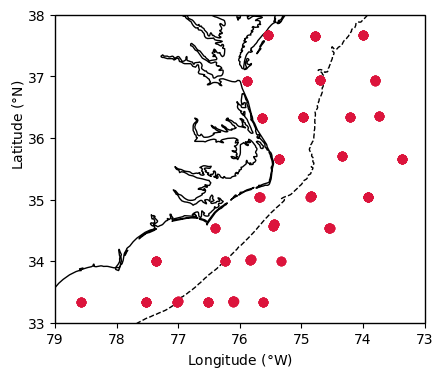

In [5]:
make_map()
plt.scatter(df.Lon,df.Lat, color = "crimson")

*Figure 1.* Spatial distribution of N2 fixation rate measurements in x-y plane. The dashed line indicates the shelfbreak (200 m isobath).

Text(0, 0.5, 'Depth (m)')

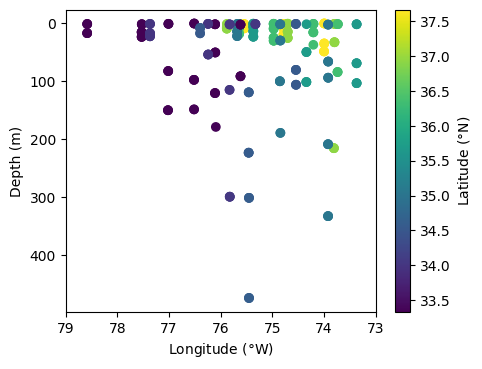

In [6]:
fig, ax = plt.subplots(1,1, figsize = (5,4), dpi = 100)
plt.scatter(df.Lon,df.Depth_m, c = df.Lat)
cb = plt.colorbar()
plt.gca().invert_yaxis()
ax.set_xlim([-79,-73])
ax.set_xticks(np.arange(-79,-72,1))
ax.set_xticklabels([79,78,77,76,75,74,73])

cb.set_label('Latitude ($\degree$N)')
plt.xlabel('Longitude ($\degree$W)')
plt.ylabel('Depth (m)')

*Figure 2.* Spatial distribution of N2 fixation rate measurements in x-z plane.

## Predictor data

#### Import predictor dataset 1:  High-resolution CTD profiles

In [7]:
infile = '..\Data\Sharp16_compiledCTDdata_downcasts.csv' # This file contains all downcasts from cruise
hydro = pd.read_csv(infile)
hydro.columns

Index(['Cast', 'Cond_Sm', 'Cond2_Sm', 'Dens_kgm3', 'SigmaTheta_kgm3',
       'Sigmat_kgm3', 'Dens2_kgm3', 'SigmaTheta2_kgm3', 'Sigmat2_kgm3',
       'Depth_m', 'Fluor_mgm3', 'Lat', 'Lon', 'DO_umolkg', 'DO_uM',
       'PotTemp_C', 'PotTemp2_C', 'Press_db', 'Sal', 'Sal2', 'SeafloorDepth_m',
       'Temp_C', 'Temp2_C'],
      dtype='object')

#### Spatial and temporal coverage of predictor dataset 1 (CTD profiles)

All profiles were collected between Aug 7, 2016 and Aug 16, 2016. I will consider these as a "snapshot" view of regional hydrography.

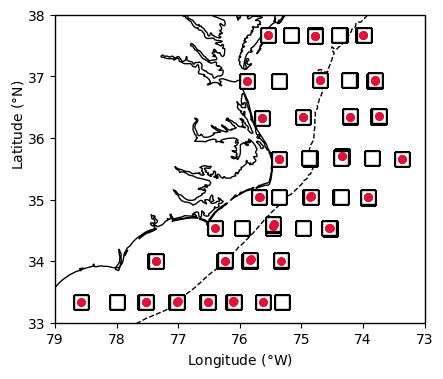

In [8]:
make_map()
plt.scatter(hydro.Lon,hydro.Lat, marker = 's', facecolor = 'w', edgecolor = 'k', s = 100)
plt.scatter(df.Lon,df.Lat, color = "crimson", s = 25)

*Figure 3.* Spatial distribution of CTD profiles (white squares) and N2 fixation rate measurements (crimson dots) in x-y plane. The dashed line indicates the shelfbreak (200 m isobath).

Text(0, 0.5, 'Depth (m)')

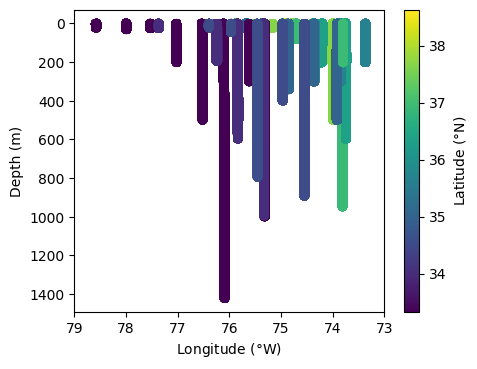

In [9]:
fig, ax = plt.subplots(1,1, figsize = (5,4), dpi = 100)
plt.scatter(hydro.Lon,hydro.Depth_m, c = hydro.Lat)
cb = plt.colorbar()
plt.gca().invert_yaxis()
ax.set_xlim([-79,-73])
ax.set_xticks(np.arange(-79,-72,1))
ax.set_xticklabels([79,78,77,76,75,74,73])

cb.set_label('Latitude ($\degree$N)')
plt.xlabel('Longitude ($\degree$W)')
plt.ylabel('Depth (m)')

*Figure 4.* Spatial distribution of CTD data in x-y plane. The dashed line indicates the shelfbreak (200 m isobath).

NOTE:  Given that direct Nfix measurements are sparse below ~250 m, I will not attempt predictions below that depth.

#### Import predictor dataset 2:  Satellite sea surface images
MODIS satellite data are mean values (temperature, chl-a, PIC, POC) from Aug 12 to 19 2016, accessed from: https://oceandata.sci.gsfc.nasa.gov. This time period was chosen because it is the time block for which an 8-day mean was available from NASA that most closely matched the period during which rate measurements were made (Aug 7 to 16). Each image covers approximately the same area, from -80 to -70 degW and 30 to 40 degN at 4 km resolution.

Salinity data are from the JPL SMAP dataset (V4.3 released March 18 2020, https://podaac.jpl.nasa.gov/smap). The 8-day running mean for Aug 15 2016 (Aug 12 - 19) was retrieved to match the data available from MODIS. The resolution is 40 km--an order of magnitude greater than that of the MODIS data.

In addition to hydrographic parameters, seafloor depth is available from the ETOPO1 1 Arc-Minute Global Relief Model (https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ngdc.mgg.dem:316), which was read in above to generate maps.

In [10]:
# sst data from https://oceandata.sci.gsfc.nasa.gov; accessed 2020-3-19
# units:  degrees Celsius

# CITATION: NASA Goddard Space Flight Center, O.B.P.G. (2018 Reprocessing) Moderate-resolution Imaging Spectroradiometer 
# (MODIS) Aqua Chlorophyll Data. NASA Ocean Biology Distibuted Active Archive Center (OB.DAAC), Goddard Space Flight Center,
# Greenbelt, MD. https://oceancolor.gsfc.nasa.gov/

infile = '../Data/AQUA_MODIS.20160812_20160819.L3m.8D.SST.x_sst.nc'
df_tsat = nc.Dataset(infile)
tlat = df_tsat.variables['lat'][:]
tlon = df_tsat.variables['lon'][:]
tsat = df_tsat.variables['sst'][:]

# create an array for data; if you don't do this, you'll get error:  "x and y must be same length"
tx, ty = np.meshgrid(tlon, tlat)

df_tsat.close()

In [11]:
# chl data from https://oceandata.sci.gsfc.nasa.gov; accessed 2020-3-19
# units:  mg m^-3

# CITATION: NASA Goddard Space Flight Center, O.B.P.G. (2018 Reprocessing) Moderate-resolution Imaging Spectroradiometer 
# (MODIS) Aqua Chlorophyll Data. NASA Ocean Biology Distibuted Active Archive Center (OB.DAAC), Goddard Space Flight Center,
# Greenbelt, MD. https://oceancolor.gsfc.nasa.gov/

infile = '../Data/AQUA_MODIS20160812_20160819_L3m_8D_CHL.x_chlor_a.nc'
df_csat = nc.Dataset(infile)
clat = df_csat.variables['lat'][:]
clon = df_csat.variables['lon'][:]
csat = df_csat.variables['chlor_a'][:]

# create an array for  data; if you don't do this, you'll get error:  "x and y must be same length"
cx, cy = np.meshgrid(clon, clat)

df_csat.close()
logcsat = np.log10(csat)

C:\Users\corda\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


In [12]:
# pic data from https://oceandata.sci.gsfc.nasa.gov; accessed 2020-3-24
# units: mol m^-3 = mM

# CITATION: NASA Goddard Space Flight Center, O.B.P.G. (2018 Reprocessing) Moderate-resolution Imaging Spectroradiometer 
# (MODIS) Aqua Chlorophyll Data. NASA Ocean Biology Distibuted Active Archive Center (OB.DAAC), Goddard Space Flight Center,
# Greenbelt, MD. https://oceancolor.gsfc.nasa.gov/

infile = '../Data/A20162252016232.L3m_8D_PIC.x_pic.nc'
pic_df = nc.Dataset(infile)
piclat = pic_df.variables['lat'][:]
piclon = pic_df.variables['lon'][:]
pic = pic_df.variables['pic'][:]

# create an array for data; if you don't do this, you'll get error:  "x and y must be same length"
pix, piy = np.meshgrid(piclon, piclat)

pic_df.close()

pic.shape

(240, 240)

In [13]:
# poc data from https://oceandata.sci.gsfc.nasa.gov; accessed 2020-3-24
# units:  mg m^-3

# CITATION: NASA Goddard Space Flight Center, O.B.P.G. (2018 Reprocessing) Moderate-resolution Imaging Spectroradiometer 
# (MODIS) Aqua Chlorophyll Data. NASA Ocean Biology Distibuted Active Archive Center (OB.DAAC), Goddard Space Flight Center,
# Greenbelt, MD. https://oceancolor.gsfc.nasa.gov/

infile = '../Data/A20162252016232.L3m_8D_POC.x_poc.nc'
poc_df = nc.Dataset(infile)
poclat = poc_df.variables['lat'][:]
poclon = poc_df.variables['lon'][:]
poc = poc_df.variables['poc'][:]

# create an array for data; if you don't do this, you'll get error:  "x and y must be same length"
pox, poy = np.meshgrid(poclon, poclat)

poc_df.close()

poc.shape

(240, 240)

In [14]:
# Total particulate carbon was measured on-board. Here I calculate it from MODIS PIC and POC concentrations.

# Standardize units
poc_uM = poc/(12.011) # 1 mmol C = 12.011 mg C; 1 m^3 = 1000 L
pic_uM = pic*1000

pcsat = poc_uM + pic_uM
logpcsat = np.log10(pcsat)

C:\Users\corda\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


In [15]:
# sal data from https://podaac-tools.jpl.nasa.gov/drive/files/allData/smap/L3/JPL/V4.3/8day_running/2016/224; accessed 2020-3-27
# units: psu

# CITATION:  Fore, A., S. Yueh, W. Tanh, A. Hayashi, 2020:  JPL SMAP Ocean Surface Salinity Products [Level 2B, 
# Level 3 Running 8-day, Level 3 Monthly], Version 4.3 validated release. Jet Propulsion Laboratory, Pasadena, CA, USA.

infile = '../Data/SMAP_L3_SSS_20160815_8DAYS_V4.3.nc'
df_ssat = nc.Dataset(infile)
ssat = df_ssat.variables['smap_sss'][:]
slat = df_ssat.variables['latitude'][:]
slon = df_ssat.variables['longitude'][:]

# create an array for data; if you don't do this, you'll get error:  "x and y must be same length"
sx, sy = np.meshgrid(slon, slat)

df_ssat.close()

#### Spatial and temporal coverage of predictor dataset 2 (satellite images)

All satellite data are 8-day means from Aug 12 - 19, 2016. As with the rate measurements, I will consider these as a "snapshot" of N2 fixation for the region. The salinity data are at the lowest resolution and, consequently, will limit the resolution at which we can predict Nfix.

Text(0.5, 1.0, 'MODIS sea surface temperature')

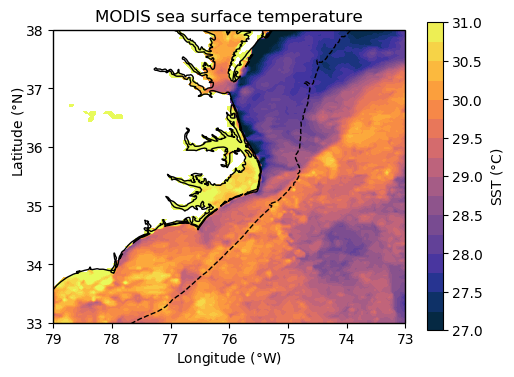

In [16]:
palette = 'cmo.thermal'

make_map()
CS = plt.contourf(tx, ty, tsat, levels = 100, zorder = -1, cmap = palette, vmin = 27, vmax = 31)
m = plt.cm.ScalarMappable(cmap=palette)
m.set_array(tsat)
m.set_clim(27, 31)
cb = plt.colorbar(m, boundaries=np.linspace(27, 31, 17))
cb.set_label('SST ($\degree$C)')
plt.title('MODIS sea surface temperature')

*Figure 5.*  Mean MODIS sea surface temperature from Aug. 12 to 19th, 2016. Dashed line indicates the shelfbreak (200 m isobath).

Text(0.5, 1.0, 'MODIS sea surface [chl-a]')

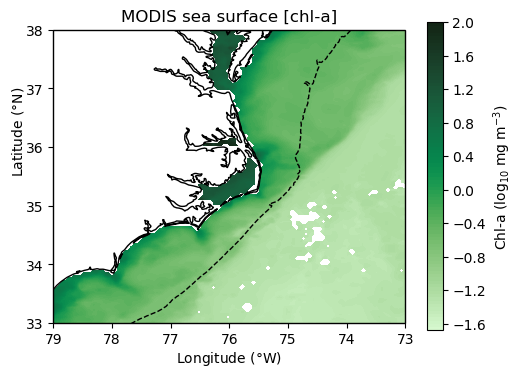

In [17]:
palette = 'cmo.algae'

make_map()
CS = plt.contourf(cx, cy, logcsat, levels = 100, zorder = -1, cmap = palette)
cb = plt.colorbar()
cb.set_label('Chl-a (log$_{10}$ mg m$^{-3}$)')
plt.title('MODIS sea surface [chl-a]')

*Figure 6.*  Mean MODIS sea surface chlorophyll-a concentration from Aug. 12 to 19th, 2016. Dashed line indicates the shelfbreak (200 m isobath).

Text(0.5, 1.0, 'MODIS sea surface [PC]')

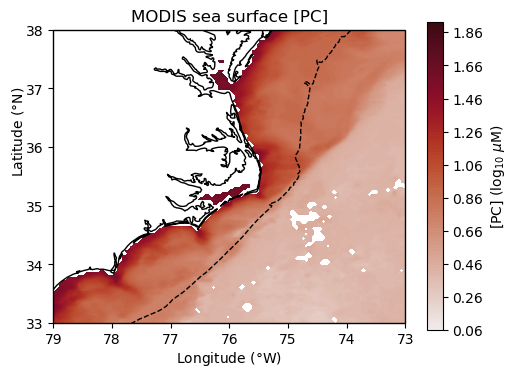

In [18]:
palette = 'cmo.amp'

make_map()
CS = plt.contourf(pix, piy, logpcsat, levels = 100, zorder = -1, cmap = palette)
cb = plt.colorbar()
cb.set_label('[PC] (log$_{10}$ $\mu$M)')
plt.title('MODIS sea surface [PC]')

*Figure 7.*  Mean MODIS sea surface PIC + POC concentration from Aug. 12 to 19th, 2016. Dashed line indicates the shelfbreak (200 m isobath).

NOTE:  Pattern looks a lot like chlorophyll as PC is dominated by POC, which is composed mostly of living, photosynthetic cells at the surface. These parameters are likely redundant.

Text(0.5, 1.0, 'SMAP sea surface salinity')

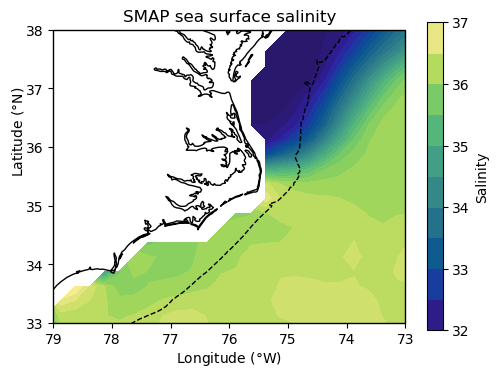

In [19]:
palette = 'cmo.haline'

make_map()
vmin = 32
vmax = 37
CS = plt.contourf(sx, sy, ssat, levels = 250, zorder = -1, cmap = palette, vmin = vmin, vmax = vmax)
m = plt.cm.ScalarMappable(cmap=palette)
m.set_array(ssat)
m.set_clim(vmin, vmax)
cb = plt.colorbar(m, boundaries=np.linspace(vmin, vmax, (2*(vmax - vmin) + 1)))
cb.set_label('Salinity')
plt.title('SMAP sea surface salinity')

*Figure 8.*  Mean SMAP sea surface salinity from Aug. 12 to 19th, 2016. Dashed line indicates the shelfbreak (200 m isobath). 

NOTE:  In the *in situ* data, there is a low salinity signal visible at Oregon Inlet (~35.8 degN). This is obscured here, either because the signal did not extend far enough offshore or because it was ephemeral and thus was obscured in the 8-day mean. 

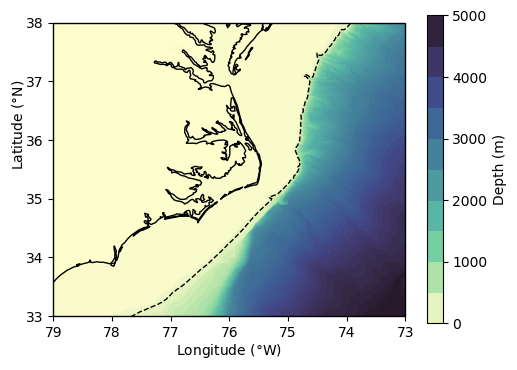

In [20]:
palette = 'cmo.deep'

make_map()
vmin = 0
vmax = 5000
CS = plt.contourf(bx, by, -bathy, levels = 100, zorder = -1, cmap = palette, vmin = vmin, vmax = vmax)
m = plt.cm.ScalarMappable(cmap=palette)
m.set_array(bathy)
m.set_clim(vmin, vmax)
cb = plt.colorbar(m, boundaries=np.linspace(vmin, vmax, 11))
cb.set_label('Depth (m)')

*Figure 9.*  ETOPO1 bathymetry map.

## Overlap in coverage and resolution of different datasets

The target data and their corresponding predictor data represent a subset of the CTD dataset that is relatively well-distributed spatially (Fig. 3). Rate measurements were made at multiple depths along every transect. Few N2 fixation rate measurements, however, were made below ~250 m (Fig. 2). Consequently, the model built from the target dataset will likely be unable to accurately resolve N2 fixation rates at greater depths where there is CTD data (Fig. 4).

There are 27 triplicate surface rate measurements (81 data points in total; Fig. 10). These are reasonably well-distributed across the shelfbreak. The SMAP salinity data does not extend as close inshore as some measured rates and the MODIS satellite data. This salinity data will probably set the western edge of the area for which Nfix will be predicted, as well as the resolution of predictions. The measured rates do not extend to the southeast or northeast corners of the area where satellite data were collected (79 to 73 degW x 33 to 38 degN) as the study was focused on the shelfbreak. These areas may need to be eliminated from the area for which Nfix rates will be predicted.

Finally, the temporal coverage is more or less the same. I wasn't able to get 8-day mean MODIS data for the exact period of time during which Nfix rates were measured, however, the time frames are of similar length and overlap significantly.

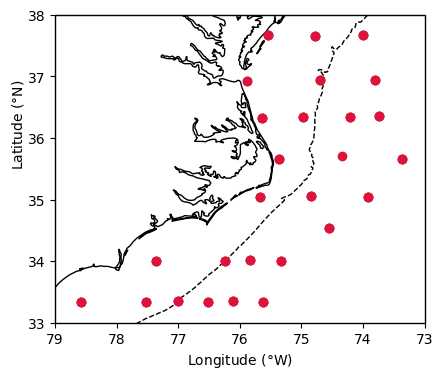

In [21]:
sfc = df[(df.Depth_m < 5) & (df.NFR_flag != 1)]

make_map()
plt.scatter(sfc.Lon,sfc.Lat, color = 'crimson')

*Figure 1.* Spatial distribution of **surface** N2 fixation rate measurements in x-y plane. The dashed line indicates the shelfbreak (200 m isobath). The gaps in the 34.5 degN transect are due to analytical issues that arose (e.g., reduction column failure, not enough PN mass on filter to determine 15N enrichment i.e. out of linear range, etc.)